# R-CNN 部分实现

R-CNN由以下三部分组成：

+ 选择性搜索算法

+ 卷积神经网络

+ 线性分类器(SVM)

受限于目前水平，只是粗略的复现了R-CNN。精细部分，如有机会，再做补充。

检测器处理流程：

1. Input image,

2. 使用select search算法，生成region proposal, 

3. 使用CNNs，逐一计算region
    
    i. 将region固定到227\*227像素大小
    
    ii.使用AlexNet模型，计算特征向量
    
    iii.使用线性SVM分类器，得到分类结果 

## 检测器的代码实现：

In [1]:
import torch
import cv2

import torch.nn as nn
from torchvision.transforms import transforms
from torchvision.models import alexnet 

In [2]:
def get_model(device=None):
    # 加载CNN模型
    model = alexnet(pretrained=True)
    num_classes = 1000
    # num_features = model.classifier[6].in_features
    # model.classifier[6] = nn.Linear(num_features, num_classes)
    # model.load_state_dict(torch.load('./models/best_linear_svm_alexnet_car.pth'))
    model.classifier[6].out_features=num_classes
    model.eval()
    # 取消梯度追踪
    for param in model.parameters():
        param.requires_grad = False
    if device:
        model = model.to(device)

    return model

In [3]:
model=get_model()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### 寻找1000类别中，小汽车对应的类别idx

定义xml解析函数，返回标注的边界框坐标

In [4]:
import xmltodict
import numpy as np  
def parse_xml(xml_path):
    """
    解析xml文件，返回标注边界框坐标
    """
    # print(xml_path)
    with open(xml_path, 'rb') as f:
        xml_dict = xmltodict.parse(f)
        # print(xml_dict)

        bndboxs = list()
        objects = xml_dict['annotation']['object']
        if isinstance(objects, list):
            for obj in objects:
                obj_name = obj['name']
                difficult = int(obj['difficult'])
                if 'car'.__eq__(obj_name) and difficult != 1:
                    bndbox = obj['bndbox']
                    bndboxs.append((int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])))
        elif isinstance(objects, dict):
            obj_name = objects['name']
            difficult = int(objects['difficult'])
            if 'car'.__eq__(obj_name) and difficult != 1:
                bndbox = objects['bndbox']
                bndboxs.append((int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])))
        else:
            pass

        return np.array(bndboxs)


定义选择性搜索算法，返回rects

In [5]:
def selectSearch(img_path): 
    image=cv2.imread(img_path,cv2.IMREAD_COLOR)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()

    # ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    
    return rects

将region的尺寸转为227\*227

In [6]:
# 尺寸转换
# 将proposal region的大小，转为227*227

def get_transform():
    # 数据转换
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((227, 227)),
        # transforms.Pad(padding=True,padding_mode='edge'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform


trans=get_transform()

寻找小汽车对应的idx

In [7]:
img_1='./000012.jpg'
xml_1='./000012.xml'

gtbox=parse_xml(xml_1)

In [8]:
x1,y1,x2,y2=gtbox[0]
print(x1,y1,x2,y2)
gtbox

156 97 351 270


array([[156,  97, 351, 270]])

In [9]:
import matplotlib.pyplot as plt
# import numpy as np

def drow_gtbox(img_path,gtbox,text='ground_truth'):
    xmin,ymin,xmax,ymax=gtbox[0]
    
    image=cv2.imread(img_1,cv2.IMREAD_COLOR)
    # 边界框
    cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,255), thickness=0)
    # 标注groung_truth
    cv2.putText(image,text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255,0), 1)
    tmp=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(tmp)

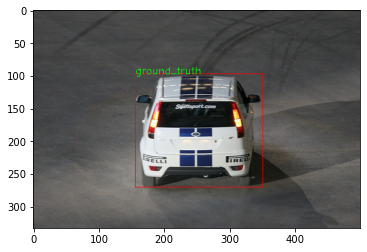

In [10]:
drow_gtbox(img_1,gtbox)

使用了pytorch官方的预训练模型，有1000个类别，所以需要知道idx和label

In [11]:
image=cv2.imread(img_1,cv2.IMREAD_COLOR)

img=trans(image)

output=model(img.unsqueeze(0))[0]
print(torch.argmax(output).item())

898


In [12]:
image2=cv2.imread('./000007.jpg',cv2.IMREAD_COLOR)
img2=trans(image2)
output2=model(img.unsqueeze(0))[0]
# output2.shape #1000
print(torch.argmax(output2).item())

898


In [13]:
output.shape

torch.Size([1000])

在ground_truth的基础上，偏移边界框，看是否还能输出该类别。

In [14]:
def get_wh(gtbox):
    xmin,ymin,xmax,ymax=gtbox[0]
    x=min(xmin,xmax);y=min(ymin,ymax)
    w=abs(xmax-xmin);h=abs(ymax-ymin)
    return x,y,w,h

def wh2box(box):
    x,y,w,h=box
    xmin=x;ymin=y
    xmax=x+w;ymax=y+h
    return np.array([[xmin,ymin, xmax, ymax]])


In [15]:
tmp_region=np.array([[156,  97, 351, 270]])  # xmin.ymin,xmax,ymax

box=get_wh(tmp_region)
print(box)  # x,y,w,h

(156, 97, 195, 173)


In [16]:
# box=(156, 97, 195, 173)  # x,y,w,h
box=(156, 100, 191, 180)
gtbox=wh2box(box)
gtbox   #  xmin,ymin,xmax,ymax

array([[156, 100, 347, 280]])

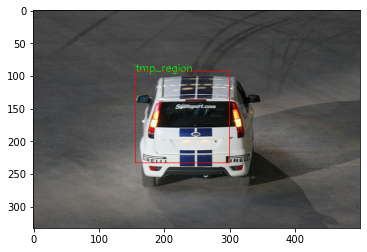

In [17]:
# new_box=(156, 97, 195, 173)  # x,y,w,h
# ground_truth

# new_box=(150, 150, 190, 120)  # x,y,w,h
# tmp_region

new_box=(156, 93, 144, 140)

new_gtbox=wh2box(new_box)

drow_gtbox(img_1,new_gtbox,text='tmp_region')

In [18]:
img=cv2.imread(img_1,cv2.IMREAD_COLOR)
print(img.shape)

(333, 500, 3)


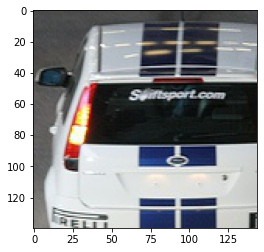

In [19]:
xmin,ymin,xmax,ymax=new_gtbox[0]

t=img[ymin:ymax,xmin:xmax]   # [y,x,:]

plt.imshow(cv2.cvtColor(t, cv2.COLOR_BGR2RGB))

In [20]:
# idx

region=t
img=trans(region)
output=model(img.unsqueeze(0))[0]
print(torch.argmax(output).item())

713


In [21]:
p=torch.softmax(output, dim=0).cpu().numpy()
print(p[1])   # ground_truth 对应的是p[idx]
# p.shape   #1000,

2.8019684e-07


In [23]:
p[713]

0.9007998

如果按照ground_truth对应的图像区域，那么预训练的Alexnet网络，应该输出的类别的idx为713.

所以，设置idx=713

## 显示region

selectsearch算法返回的是rects集合，坐标类型是x,y,w,h

cv2.rectangle()使用的坐标是xmin,ymin,xmax,ymax

In [24]:
rects=selectSearch(img_1)

len(rects)

1532

In [25]:
image=cv2.imread(img_1,cv2.IMREAD_COLOR)

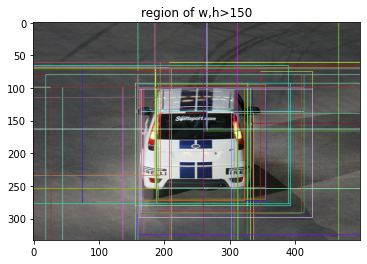

In [26]:
import random
import copy

dst=image.copy()

# 显示region
for x,y,w,h in rects:  # rects[100:200]
    if w>150 and h>150:
        # if(120< x < 190):print(x,y,w,h)
        color = [random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(dst, (x,y), (x+w, y+h), color, thickness=0)

tmp=cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.title('region of w,h>150')
plt.imshow(tmp)

使用CNNs预测每个region proposal 的idx


小汽车的idx=713

In [27]:
# start = time.time()


# 保存正样本box及其得分
positive_list =[]
score_list = []


# 1000个类别中，小汽车对应的idx
idx=713

svm_thresh=0.4   #0.4  没有经过训练的softmax线性层，输出的ground_truth对应的prob[1]=7.73,softmax之后，没有进行归一化处理

image=cv2.imread(img_1,cv2.IMREAD_COLOR)
# dst=image.copy()

for i,rect in enumerate(rects):
    
    bbox=wh2box(rect)   # rect: x,y,w,h
    xmin,ymin,xmax,ymax=bbox[0]
    # 根据坐标，获得region
    region = image[ymin:ymax,xmin:xmax]
    
    # 将region大小转为227*227
    img = trans(region)
    
    # 使用CNNs，提取出特征向量
    output = model(img.unsqueeze(0))[0]
    
    if i % 150 ==0:    print('%d / 1532' % (i) )
    # output.shape为(1000,)
    if torch.argmax(output).item() == idx:  
        """
        预测为idx
        """
        probs = torch.softmax(output, dim=0).cpu().numpy()

        if probs[idx] > svm_thresh:
            score_list.append(probs[idx])
            positive_list.append(rect)

0 / 1532
150 / 1532
300 / 1532
450 / 1532
600 / 1532
750 / 1532
900 / 1532
1050 / 1532
1200 / 1532
1350 / 1532
1500 / 1532


In [28]:
print(len(score_list))
len(positive_list)

91


91

In [30]:
for i in positive_list[:2]:
    print(i)
    print(type(i))
    break

[266 112  70  82]
<class 'numpy.ndarray'>


经过晒选，得到了预测类别=idx 的region, 显示这些region

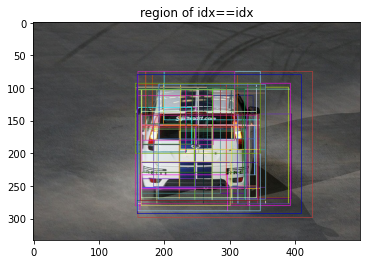

In [31]:

dst=image.copy()
for x,y,w,h in positive_list:
    color = [random.randint(0, 255) for j in range(0, 3)]
    cv2.rectangle(dst, (x,y), (x+w, y+h), color, thickness=0)

tmp=cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.title('region of idx==idx')
plt.imshow(tmp)

### 使用非极大值抑制(NMS),保留最佳边界框预测


首先定义函数：计算两个region的IOU

In [32]:
import numpy as np 

def iou(rect_a, rect_b):
    # rect_a: [x,y,w,h]
    a_w,a_h=rect_a[2],rect_a[3]
    b_w,b_h=rect_b[2],rect_b[3]
    
    # x,y,w,h to xmin,ymin,xmax,ymax  
    a_xmin,a_ymin,a_xmax,a_ymax=wh2box(rect_a)[0] #[0]
    b_xmin,b_ymin,b_xmax,b_ymax=wh2box(rect_b)[0]
    
    # iou_w,iou_h
    iou_w=min(a_xmin,a_xmax,b_xmin,b_xmax)+a_w+b_w-max(a_xmin,a_xmax,b_xmin,b_xmax)
    iou_h=min(a_ymin,a_ymax,b_ymin,b_ymax)+a_h+b_h-max(a_ymin,a_ymax,b_ymin,b_ymax)

    # 计算交并比
    iou_ratio=0.0
    if iou_w <=0 or iou_w<=0:
        # 无交集
        iou_ratio=0.0
    else:
        # 计算交集面积
        intersection = iou_w * iou_h
        # 计算两个边界框的面积
        a_area=a_w * a_h
        b_area=b_w * b_h
        # 交并比
        iou_ratio = intersection / (a_area + b_area - intersection)
    return iou_ratio

0.12253581052333003

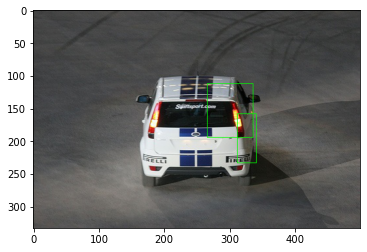

In [33]:
# test 1

t_img=image.copy()

for x,y,w,h in positive_list[:2]:
    cv2.rectangle(t_img, (x,y), (x+w, y+h),(0,255,0), thickness=0)
    tmp=cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
    plt.imshow(tmp)

rect_a=positive_list[0]
rect_b=positive_list[1]

iou(rect_a,rect_b)

In [34]:
# test 2

# a=[0,0,1,1]
# b=[0,0,2,2]
# print(iou(a,b))  # 0.25

# a=[0,0,1,1]
# b=[1,1,2,2]
# print(iou(a,b))  # 0.0


a=[0,0,1,1]
b=[2,2,3,3]
print(iou(a,b))  # 0.0

0.0


定义非极大值抑制实现函数

In [35]:
rect_array = np.array(positive_list)
score_array = np.array(score_list)


In [36]:
t0=np.argsort(score_array)
t1=np.argsort(score_array)[::-1]
print(t0[0],t0[-1])
print(t1[0],t1[-1])

67 40
40 67


In [37]:
print(rect_array[0])
print(score_array[0])

rect_array2=rect_array[t1]
scores_array2=score_array[t1]

print(rect_array2[0])
print(scores_array2[0])

[266 112  70  82]
0.8709241
[165 163  82 109]
0.97843575


In [48]:
# t1.shape  # 91
t1[90]

67

计算IOU的那个函数，使用np的矩阵运算，速度比价快，暂时先这样，之后再改。

In [76]:
def nms(rect_list, score_list):

    rect_array = np.array(rect_list)
    score_array = np.array(score_list)

    # 按照p[idx]的概率得分score, 进行排序，记住对应的idx
    # 使用[::-1], 达到倒序效果
    idxs = np.argsort(score_array)[::-1]
    print('len(idxs)',len(idxs))
    # 按照idxs, 更新rect_array和score_array的排列
    # rect_array = rect_array[idxs]
    # score_array = score_array[idxs]
    
    nms_rects = list()
    nms_scores = list()

    thresh = 0.2
    while len(idxs)>0:
        
        idx=idxs[0]
        
        # 添加scores最大的边界框
        nms_rects.append(rect_array[idx])
        nms_scores.append(score_array[idx])
        
        # 如果这是最后一个边界框
        num=len(idxs)
        if num - 1 == 0 : 
            break
        print('num: ',num)

        tmp_idxs=[]

        # 计算IoU，只保留交并比小于阈值的边界框
        tmp_idxs=[]
        for i in idxs[1:]:
            iou_ratio = iou(rect_array[idx],rect_array[i])
            if iou_ratio < thresh:
                tmp_idxs.append(i)
        idxs=np.array(tmp_idxs)
    return nms_rects, nms_scores

In [77]:
bbox_list,prob_list= nms(positive_list, score_list)

len(idxs) 91
num:  91
num:  49
num:  23
num:  6
num:  2


In [78]:
len(bbox)

8

使用非极大值抑制之后，保留下来的置信度最高的region一共有8个。

接下来，画出scores 最大的 region对应的边界框

In [85]:
# import random


def draw_bbox(image_path, bbox_list, prob_list):
    # 读取 图片
    img=cv2.imread(image_path,cv2.IMREAD_COLOR)
    for i,rect in enumerate(bbox_list):
        x,y,w,h=rect
        # bbox=wh2box(rect)   # rect: x,y,w,h
        # xmin,ymin,xmax,ymax=bbox[0]
        prob = prob_list[i]

        color = [random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(img, (x, y), (x+w, y+h), color, thickness=0)
        cv2.putText(img, '%.2f' % (prob), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        plt.title('bounding boxs')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

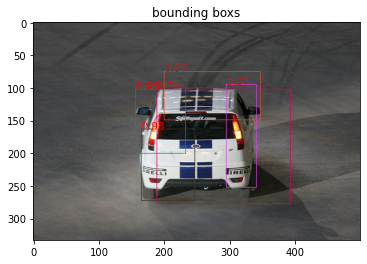

In [86]:
draw_bbox(img_1, bbox_list, prob_list)

## 小结：

本文粗略定义了一个R-CNN分类器。实现了两个部分：选择性搜索、CNNs。没有实现第三部分：线性分类器。

+ 选择性搜索算法，生成推荐区域，

+ 使用预训练的alexnet模型，得到推荐区域的特征向量，

+ 使用softmax，处理特征向量，得到类别为idx的推荐区域及其概率，


在CNNs之后，作者训练了一个线性SVM模型，用来回归边界框，以提高定位精度。